In [112]:
import pandas as pd
import numpy as np

from cleantext import clean

In [113]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


In [114]:
# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt

#Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s:%(levelname)s:%(message)s',level=logging.ERROR)

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

# NLTK stop words
from nltk.corpus import stopwords
stop_words=stopwords.words('english')
#stop_words.extend(['great','app','good','apps','really','nice'])

import datetime
import os

In [115]:
df=pd.read_csv('spotify2.csv')

In [116]:
df.shape

(485958, 12)

In [117]:
df['content']=df['content'].apply(lambda x: clean(x, no_emoji=True, no_punct=True))

In [118]:
df.head()

Unnamed: 0                              reviewId              userName  \
0           0  fa53a8f2-3ba4-4997-9c17-1707b366e0f9           Sumit Pawar   
1           1  c9e781c4-73e0-499b-949d-5ff5bb58e82c       Jagannath Swain   
2           2  4eced852-2d24-4ba8-8f8c-a5003981dd6a            AKSHAY R.S   
3           3  fc260e5f-dcd7-4f21-9104-a8525fb58893  Rozaria Martin Bryan   
4           4  7a573431-19f9-4544-86ac-1e0249f9bc06               Madison   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ALV-U...   
1  https://play-lh.googleusercontent.com/a-/ALV-U...   
2  https://play-lh.googleusercontent.com/a-/ALV-U...   
3  https://play-lh.googleusercontent.com/a-/ALV-U...   
4  https://play-lh.googleusercontent.com/a-/ALV-U...   

                                             content  score  thumbsUpCount  \
0                                      too much adds      1              0   
1  i used spotify from last 5 to 6 years but the ...      1              0   
2                                          booooring      1              0   
3  i would use spotify with adjusting the equaliz...      4              0   
4  too many ads ive had premium and i find that i...      2              1   

  reviewCreatedVersion                   at  \
0           8.8.90.893  2023-11-29 11:38:14   
1           8.5.32.889  2023-11-29 11:37:28   
2           8.8.90.893  2023-11-29 11:37:05   
3                  NaN  2023-11-29 11:36:07   
4           8.8.90.893  2023-11-29 11:31:46   

                                        replyContent            repliedAt  \
0  Hi! We’re sorry to hear this and we’ll pass yo...  2023-11-29 14:02:27   
1                                                NaN                  NaN   
2                                                NaN                  NaN   
3                                                NaN                  NaN   
4  Hey, thanks for the feedback. If you haven't t...  2020-10-06 18:29:40   

   appVersion  
0  8.8.90.893  
1  8.5.32.889  
2  8.8.90.893  
3         NaN  
4  8.8.90.893

In [119]:
df.columns

Index(['Unnamed: 0', 'reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion'],
      dtype='object')

In [120]:
df=df.drop(columns=["Unnamed: 0", 'reviewId', 'userName', 'userImage','replyContent',
       'repliedAt', 'appVersion'], axis=1)

In [123]:
# Tokenize words and Clean-up text
data= df.content.values.tolist()
def content_to_words(sentences):
    for sentence in sentences:
        yield (gensim.utils.simple_preprocess(str(sentence),deacc=True)) #deacc=True removes punctuations


In [124]:
data_words=list(content_to_words(data))
print(data_words[:1])
count=[len(sublist) for sublist in data_words ]
df['words']=data_words
df['review_len']=count
data_words=[sublist for sublist in data_words if len(sublist)>1]
df=df[df['words'].map(len) >1]

[['too', 'much', 'adds']]


In [125]:
# Creating Bigram and Trigram Models
bigram=gensim.models.Phrases(data_words,min_count=5,threshold=10) #higher threshold fewer phrase
trigram=gensim.models.Phrases(bigram[data_words],threshold=10)

#faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [126]:
def remove_stopwords(texts):
    return[[word for word in simple_preprocess(str(doc))if word not in stop_words]for doc in texts]

def make_bigram(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return[trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN','ADJ','VERB',"ADV"]):
    """https://spacy.io/api/annotation"""
    texts_out=[]
    for content in texts:
        doc=nlp(" ".join(content))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [128]:

data_words_bigram= make_bigram(data_words)
print(data_words_bigram[:1])


[['too_much', 'adds']]


In [129]:

data_words_trigram=make_trigrams(data_words)
print(data_words_trigram[:1])

[['too_much', 'adds']]


In [130]:
nlp=spacy.load("en_core_web_sm",disable=['parser,ner'])
data_lemmatized= lemmatization(data_words_trigram,allowed_postags=['NOUN','ADJ','VERB','ADV'])

print(data_lemmatized[:1])
df['words']=data_lemmatized

[['too_much', 'add']]


In [131]:
data_words_nostops= remove_stopwords(data_lemmatized)
df['words']=data_words_nostops

In [132]:
data_words_nostops=[sublist for sublist in data_words_nostops if len(sublist)>1]
df=df[df['words'].map(len) >1]

In [137]:
id2word= corpora.Dictionary(data_words_nostops)

In [138]:
#Create Corpus
texts=(data_words_nostops)

In [139]:
#Term Document Frequency
corpus=[id2word.doc2bow(text) for text in texts]

In [140]:
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [141]:
#If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.
id2word[0]

[[(id2word[id],freq) for id, freq in cp]for cp in corpus[:1]]


[[('add', 1), ('too_much', 1)]]

In [142]:

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,
                                         num_topics=num_topics,random_state=100,
                                         alpha='auto',per_word_topics=True)
        model_list.append(model)

        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

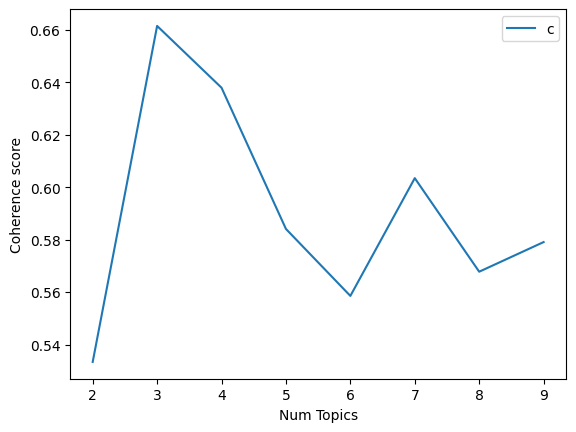

In [143]:

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=10, step=1)

#Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [149]:

lda_model= gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,
                                           num_topics=3,random_state=100,
                                           alpha='auto',per_word_topics=True)


In [150]:
from pprint import pprint
# Print the Keyword in the 10 topics
doc_lda=lda_model[corpus]
pprint(lda_model.print_topics())


[(0,
  '0.087*"spotify" + 0.020*"make" + 0.019*"new" + 0.017*"year" + '
  '0.015*"premium" + 0.014*"feature" + 0.013*"way" + 0.013*"back" + '
  '0.011*"change" + 0.009*"go"'),
 (1,
  '0.092*"app" + 0.067*"song" + 0.060*"music" + 0.047*"good" + 0.032*"play" + '
  '0.027*"listen" + 0.027*"love" + 0.024*"playlist" + 0.020*"use" + '
  '0.019*"ad"'),
 (2,
  '0.057*"great" + 0.028*"work" + 0.020*"podcast" + 0.020*"phone" + '
  '0.019*"try" + 0.017*"still" + 0.016*"fix" + 0.014*"issue" + 0.012*"stop" + '
  '0.011*"open"')]


In [151]:

#compute perplexity
lda_perplexity=lda_model.log_perplexity(corpus)
print('\nPerplexity:',lda_perplexity)# a measure of how good the model is, lower the better.


#compute coherence score
coherence_model_lda=CoherenceModel(model=lda_model,texts=texts,dictionary=id2word,coherence='c_v')
coherence_lda=coherence_model_lda.get_coherence()
print('\nCoherence Score:',coherence_lda)


Perplexity: -6.650660425576608

Coherence Score: 0.661513801741457


In [152]:

vis=pyLDAvis.gensim_models.prepare(lda_model,corpus,id2word)
pyLDAvis.save_html(vis,"final_spotify.html")


IndexError: list index out of range

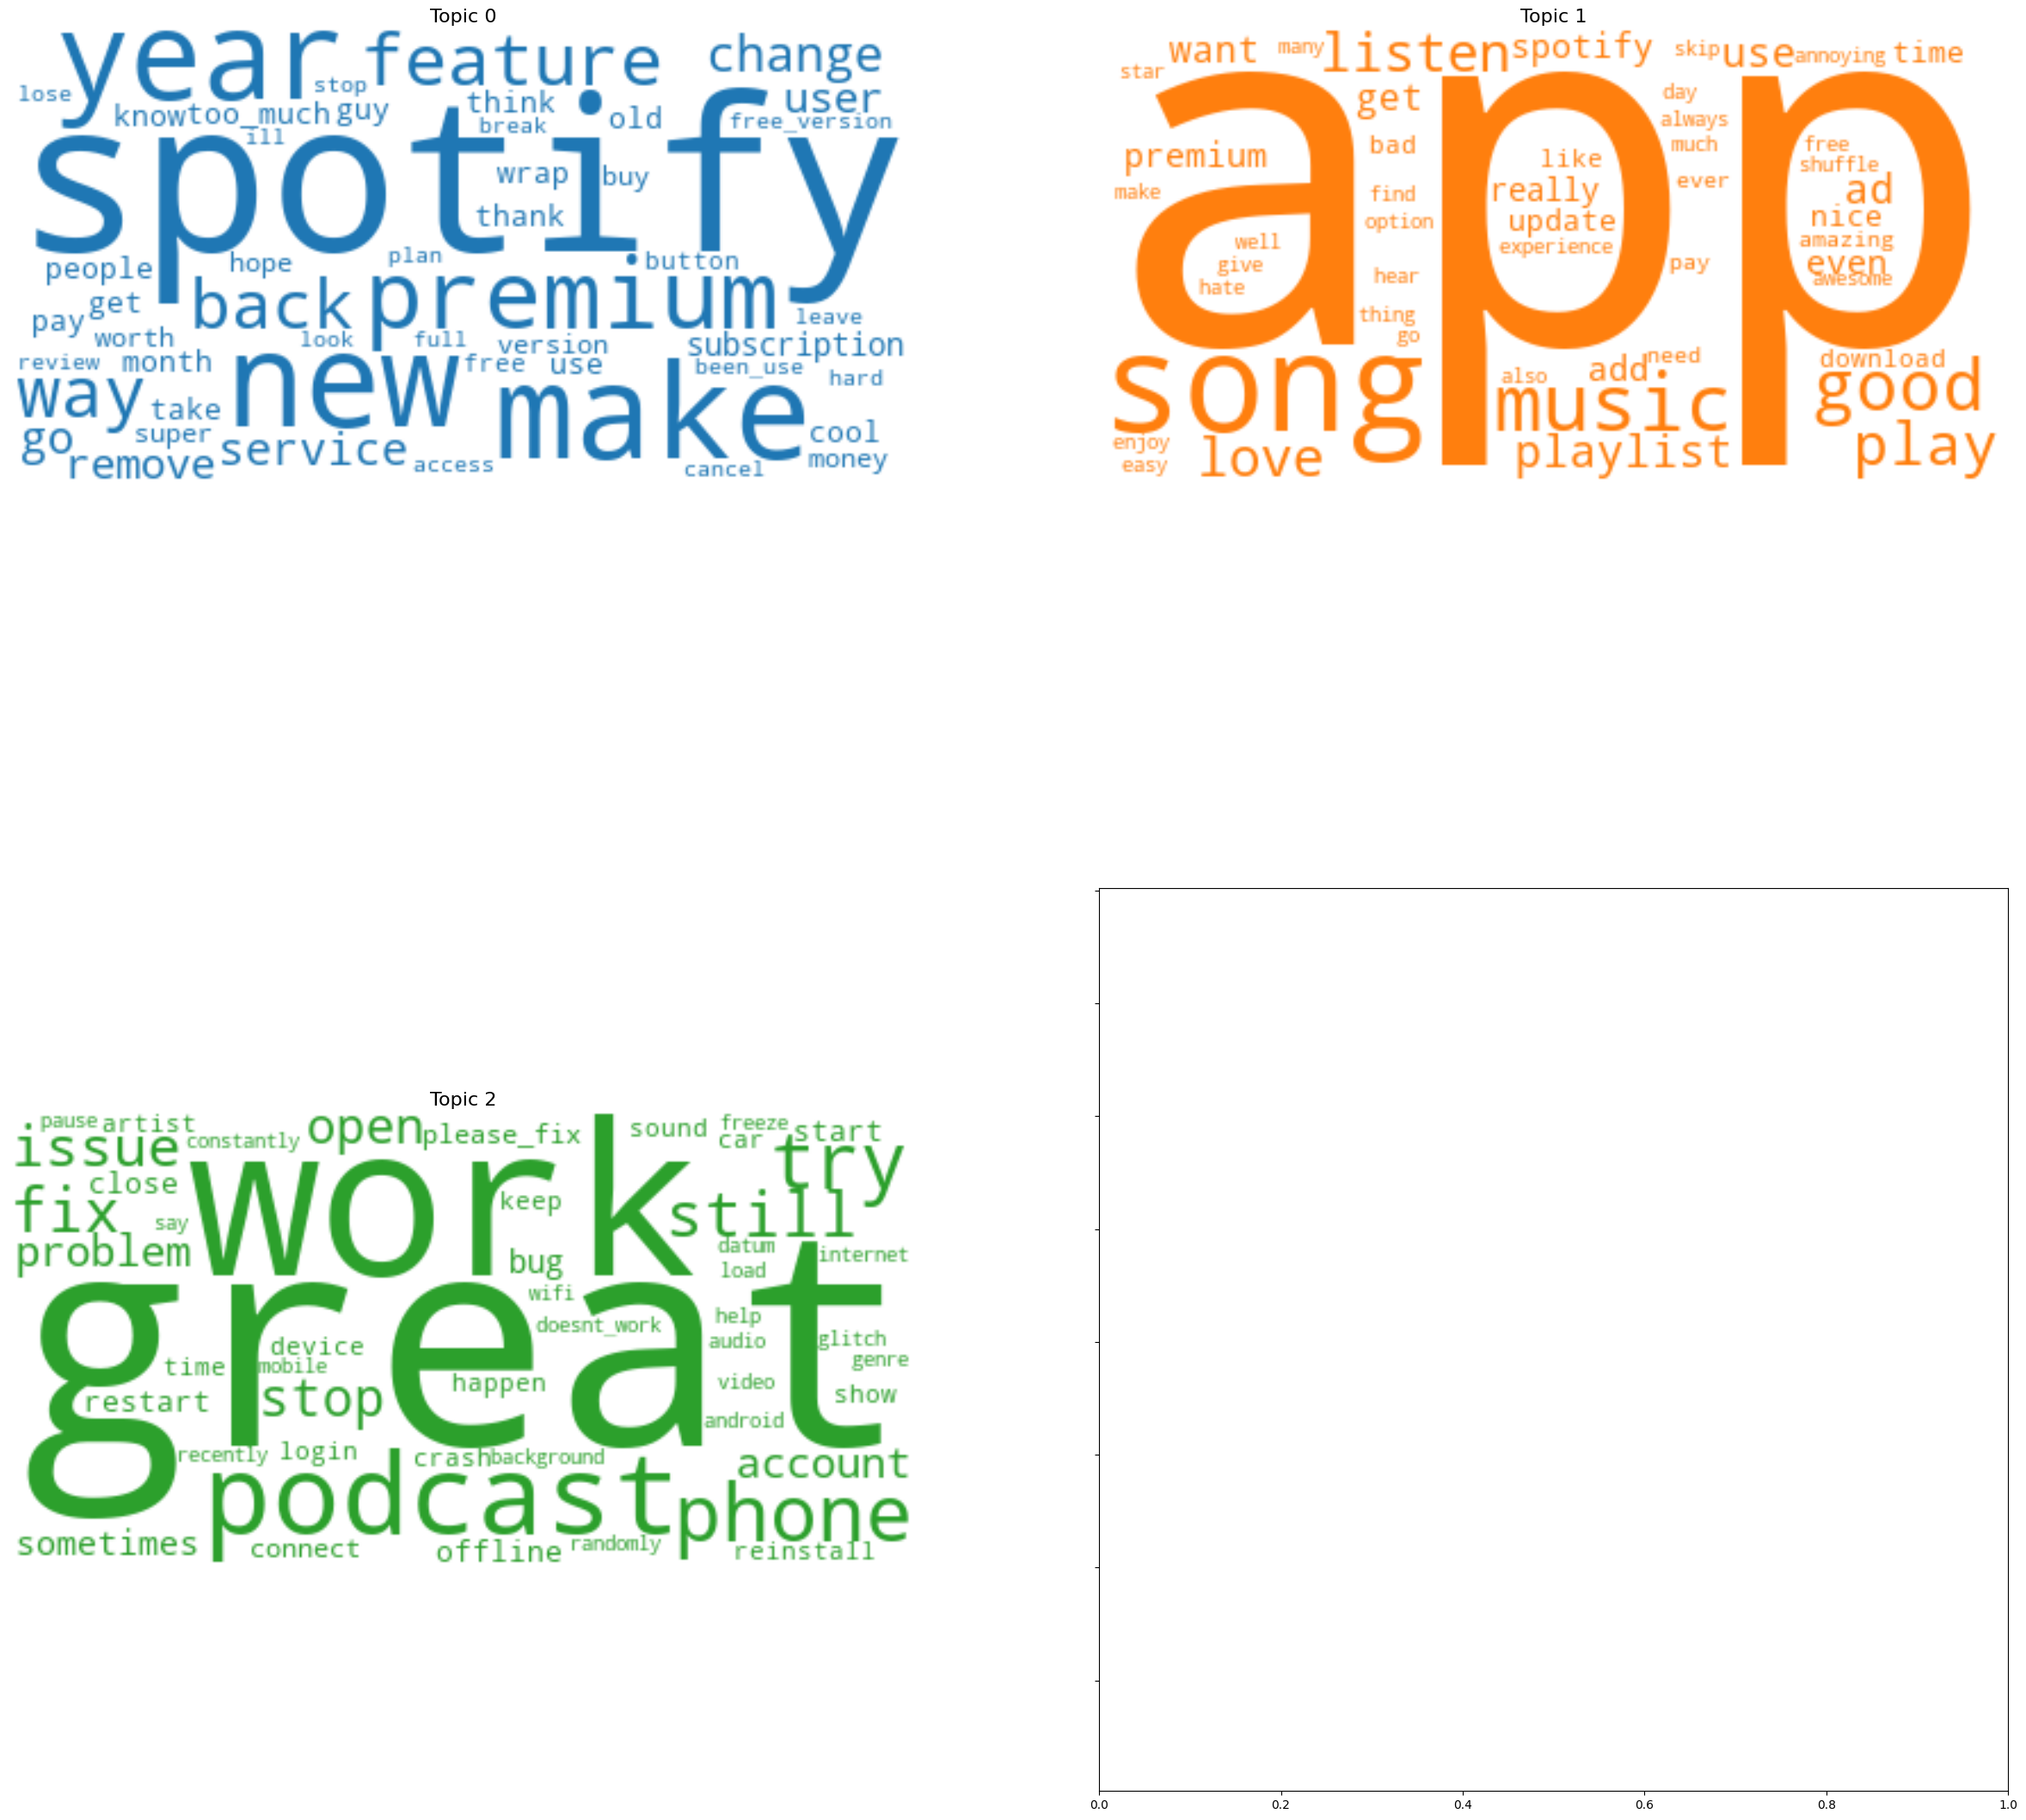

In [153]:

# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  max_words=50,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_words=50,formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(30,30), sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud,interpolation='bilinear')
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=5, hspace=5)
plt.axis('off')
plt.margins(x=5, y=5)
plt.tight_layout()
plt.show()


In [154]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics = []
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                #sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([int(topic_num), round(prop_topic,4), topic_keywords])], axis=0)
                new_row = [int(topic_num), round(prop_topic,4), topic_keywords]
                sent_topics.append(new_row)
            else:
                break
    sent_topics_df = pd.DataFrame(sent_topics, columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'] )
    # Add original text to the end of the output
    contents = pd.DataFrame(pd.Series(texts))
    contents.columns = ["Text"]
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

In [155]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)


In [156]:
df_topic_sents_keywords.head()

Dominant_Topic  Perc_Contribution  \
0               1             0.6422   
1               1             0.6393   
2               1             0.7296   
3               1             0.4496   
4               1             0.7407   

                                      Topic_Keywords  \
0  app, song, music, good, play, listen, love, pl...   
1  app, song, music, good, play, listen, love, pl...   
2  app, song, music, good, play, listen, love, pl...   
3  app, song, music, good, play, listen, love, pl...   
4  app, song, music, good, play, listen, love, pl...   

                                                Text  
0                                    [too_much, add]  
1  [use, spotify, last, year, recent_update, list...  
2  [use, spotify, adjust, equalizer, listening, e...  
3  [too_many_ad, ive_had, premium, find, alot, mo...  
4                                        [good, app]

In [157]:

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)
df[['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']]=df_dominant_topic[['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']].values


In [158]:
df.head()

content  score  thumbsUpCount  \
0                                      too much adds      1              0   
1  i used spotify from last 5 to 6 years but the ...      1              0   
3  i would use spotify with adjusting the equaliz...      4              0   
4  too many ads ive had premium and i find that i...      2              1   
5                                      very good app      5              0   

  reviewCreatedVersion                   at  \
0           8.8.90.893  2023-11-29 11:38:14   
1           8.5.32.889  2023-11-29 11:37:28   
3                  NaN  2023-11-29 11:36:07   
4           8.8.90.893  2023-11-29 11:31:46   
5           8.8.90.893  2023-11-29 11:31:14   

                                               words  review_len  \
0                                    [too_much, add]           3   
1  [use, spotify, last, year, recent_update, list...          51   
3  [use, spotify, adjust, equalizer, listening, e...          24   
4  [too_many_ad, ive_had, premium, find, alot, mo...          25   
5                                        [good, app]           3   

  Dominant_Topic Topic_Perc_Contrib  \
0              1             0.6422   
1              1             0.6393   
3              1             0.7296   
4              1             0.4496   
5              1             0.7407   

                                            Keywords  
0  app, song, music, good, play, listen, love, pl...  
1  app, song, music, good, play, listen, love, pl...  
3  app, song, music, good, play, listen, love, pl...  
4  app, song, music, good, play, listen, love, pl...  
5  app, song, music, good, play, listen, love, pl...

In [159]:

import  openpyxl
file_path = os.getcwd()
file_name = 'final_spotify_result.xlsx'
save_file = os.path.join(file_path, file_name)
df.to_excel(save_file,
                 engine='openpyxl',
                 startrow=0,
                 startcol=0,
                 header=True,
                 na_rep='NaN',
                 float_format='%.2f',
                 sheet_name='Sheet1'
                 )



In [160]:
df.columns

Index(['content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at',
       'words', 'review_len', 'Dominant_Topic', 'Topic_Perc_Contrib',
       'Keywords'],
      dtype='object')

In [161]:
df['at'] = pd.to_datetime(df["at"]).dt.date
pdate=datetime.date(2023,7,1)

In [162]:
df_before=df.loc[(df['at']<pdate)].reset_index()
df_after=df.loc[(df['at']>=pdate)].reset_index()

In [163]:
df_before.to_csv

<bound method NDFrame.to_csv of          index                                            content  score  \
0       303442                         great app for instrumental      5   
1       303443     great music easy to use and nice mix playlists      5   
2       303445  in last update your remove some things like 1r...      4   
3       303446  i dont like that after every two songs there i...      3   
4       303447  i think without advertisement is very good but...      3   
...        ...                                                ...    ...   
130304  485950                                           nice app      5   
130305  485951                       we cant play our search song      4   
130306  485952  didnt get spotify wrapped in bangladesh a comm...      1   
130307  485953                                        nice thanks      5   
130308  485954  i was using spotify for a long time but recent...      2   

        thumbsUpCount reviewCreatedVersion          at 

In [164]:
df_after.to_csv

<bound method NDFrame.to_csv of          index                                            content  score  \
0            0                                      too much adds      1   
1            1  i used spotify from last 5 to 6 years but the ...      1   
2            3  i would use spotify with adjusting the equaliz...      4   
3            4  too many ads ive had premium and i find that i...      2   
4            5                                      very good app      5   
...        ...                                                ...    ...   
224520  303432      my shot to gaze upon the beauty of musics sea      5   
224521  303433                   very easy to use app made my day      5   
224522  303434  unable to search for songs at the moment no pr...      2   
224523  303436  the app is best until it get updated now it is...      1   
224524  303437  why do you need to waste money to play music i...      1   

        thumbsUpCount reviewCreatedVersion          at 

In [165]:
len(df_before)

130309

In [166]:
len(df)

354834

In [167]:
len(df_after)

224525

Before

In [168]:
data_lemmatized1=df_before['words']
id2word1= corpora.Dictionary(data_lemmatized1)

In [169]:
texts1=(data_lemmatized1)

In [170]:
#Term Document Frequency
corpus1=[id2word1.doc2bow(text) for text in texts1]

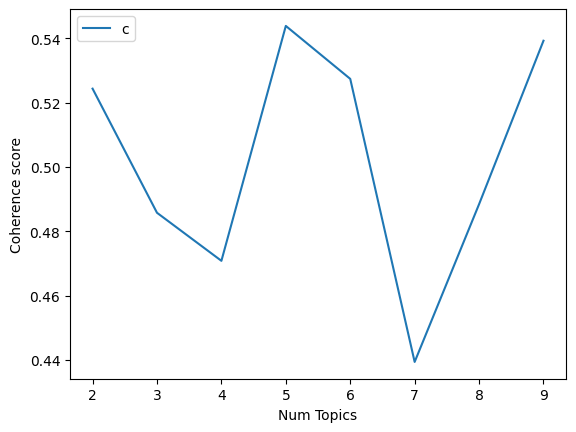

In [171]:

model_list1, coherence_values1 = compute_coherence_values(dictionary=id2word1, corpus=corpus1, texts=texts1, start=2, limit=10, step=1)

#Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [172]:

lda_model1= gensim.models.ldamodel.LdaModel(corpus=corpus1,id2word=id2word1,
                                           num_topics=5,random_state=100,
                                           alpha='auto',per_word_topics=True)


In [173]:
from pprint import pprint
doc_lda1=lda_model1[corpus1]
pprint(lda_model1.print_topics())


[(0,
  '0.141*"song" + 0.068*"play" + 0.056*"listen" + 0.053*"playlist" + '
  '0.030*"want" + 0.020*"music" + 0.017*"use" + 0.015*"spotify" + 0.014*"like" '
  '+ 0.013*"easy"'),
 (1,
  '0.027*"app" + 0.020*"spotify" + 0.018*"update" + 0.016*"even" + '
  '0.014*"work" + 0.013*"phone" + 0.012*"try" + 0.012*"fix" + 0.012*"premium" '
  '+ 0.012*"go"'),
 (2,
  '0.239*"app" + 0.154*"good" + 0.151*"music" + 0.058*"love" + 0.054*"great" + '
  '0.029*"nice" + 0.021*"ever" + 0.019*"really" + 0.016*"experience" + '
  '0.012*"use"'),
 (3,
  '0.061*"ad" + 0.036*"premium" + 0.029*"get" + 0.023*"spotify" + 0.021*"well" '
  '+ 0.020*"bad" + 0.019*"add" + 0.018*"app" + 0.017*"music" + 0.015*"pay"'),
 (4,
  '0.119*"spotify" + 0.050*"love" + 0.046*"amazing" + 0.027*"year" + '
  '0.026*"wrap" + 0.024*"awesome" + 0.013*"use" + 0.013*"thank" + '
  '0.012*"absolutely" + 0.012*"sound"')]


In [174]:

#compute perplexity
lda_perplexity1=lda_model1.log_perplexity(corpus1)
print('\nPerplexity:',lda_perplexity1)# a measure of how good the model is, lower the better.


#compute coherence score
coherence_model_lda1=CoherenceModel(model=lda_model1,texts=texts1,dictionary=id2word1,coherence='c_v')
coherence_lda1=coherence_model_lda1.get_coherence()
print('\nCoherence Score:',coherence_lda1)


Perplexity: -6.7612366166308435

Coherence Score: 0.5281332352584093


In [175]:
len(doc_lda1)

130309

In [176]:

vis1=pyLDAvis.gensim_models.prepare(lda_model1,corpus1,id2word1)
pyLDAvis.save_html(vis1,"final_spotify_before.html")


IndexError: list index out of range

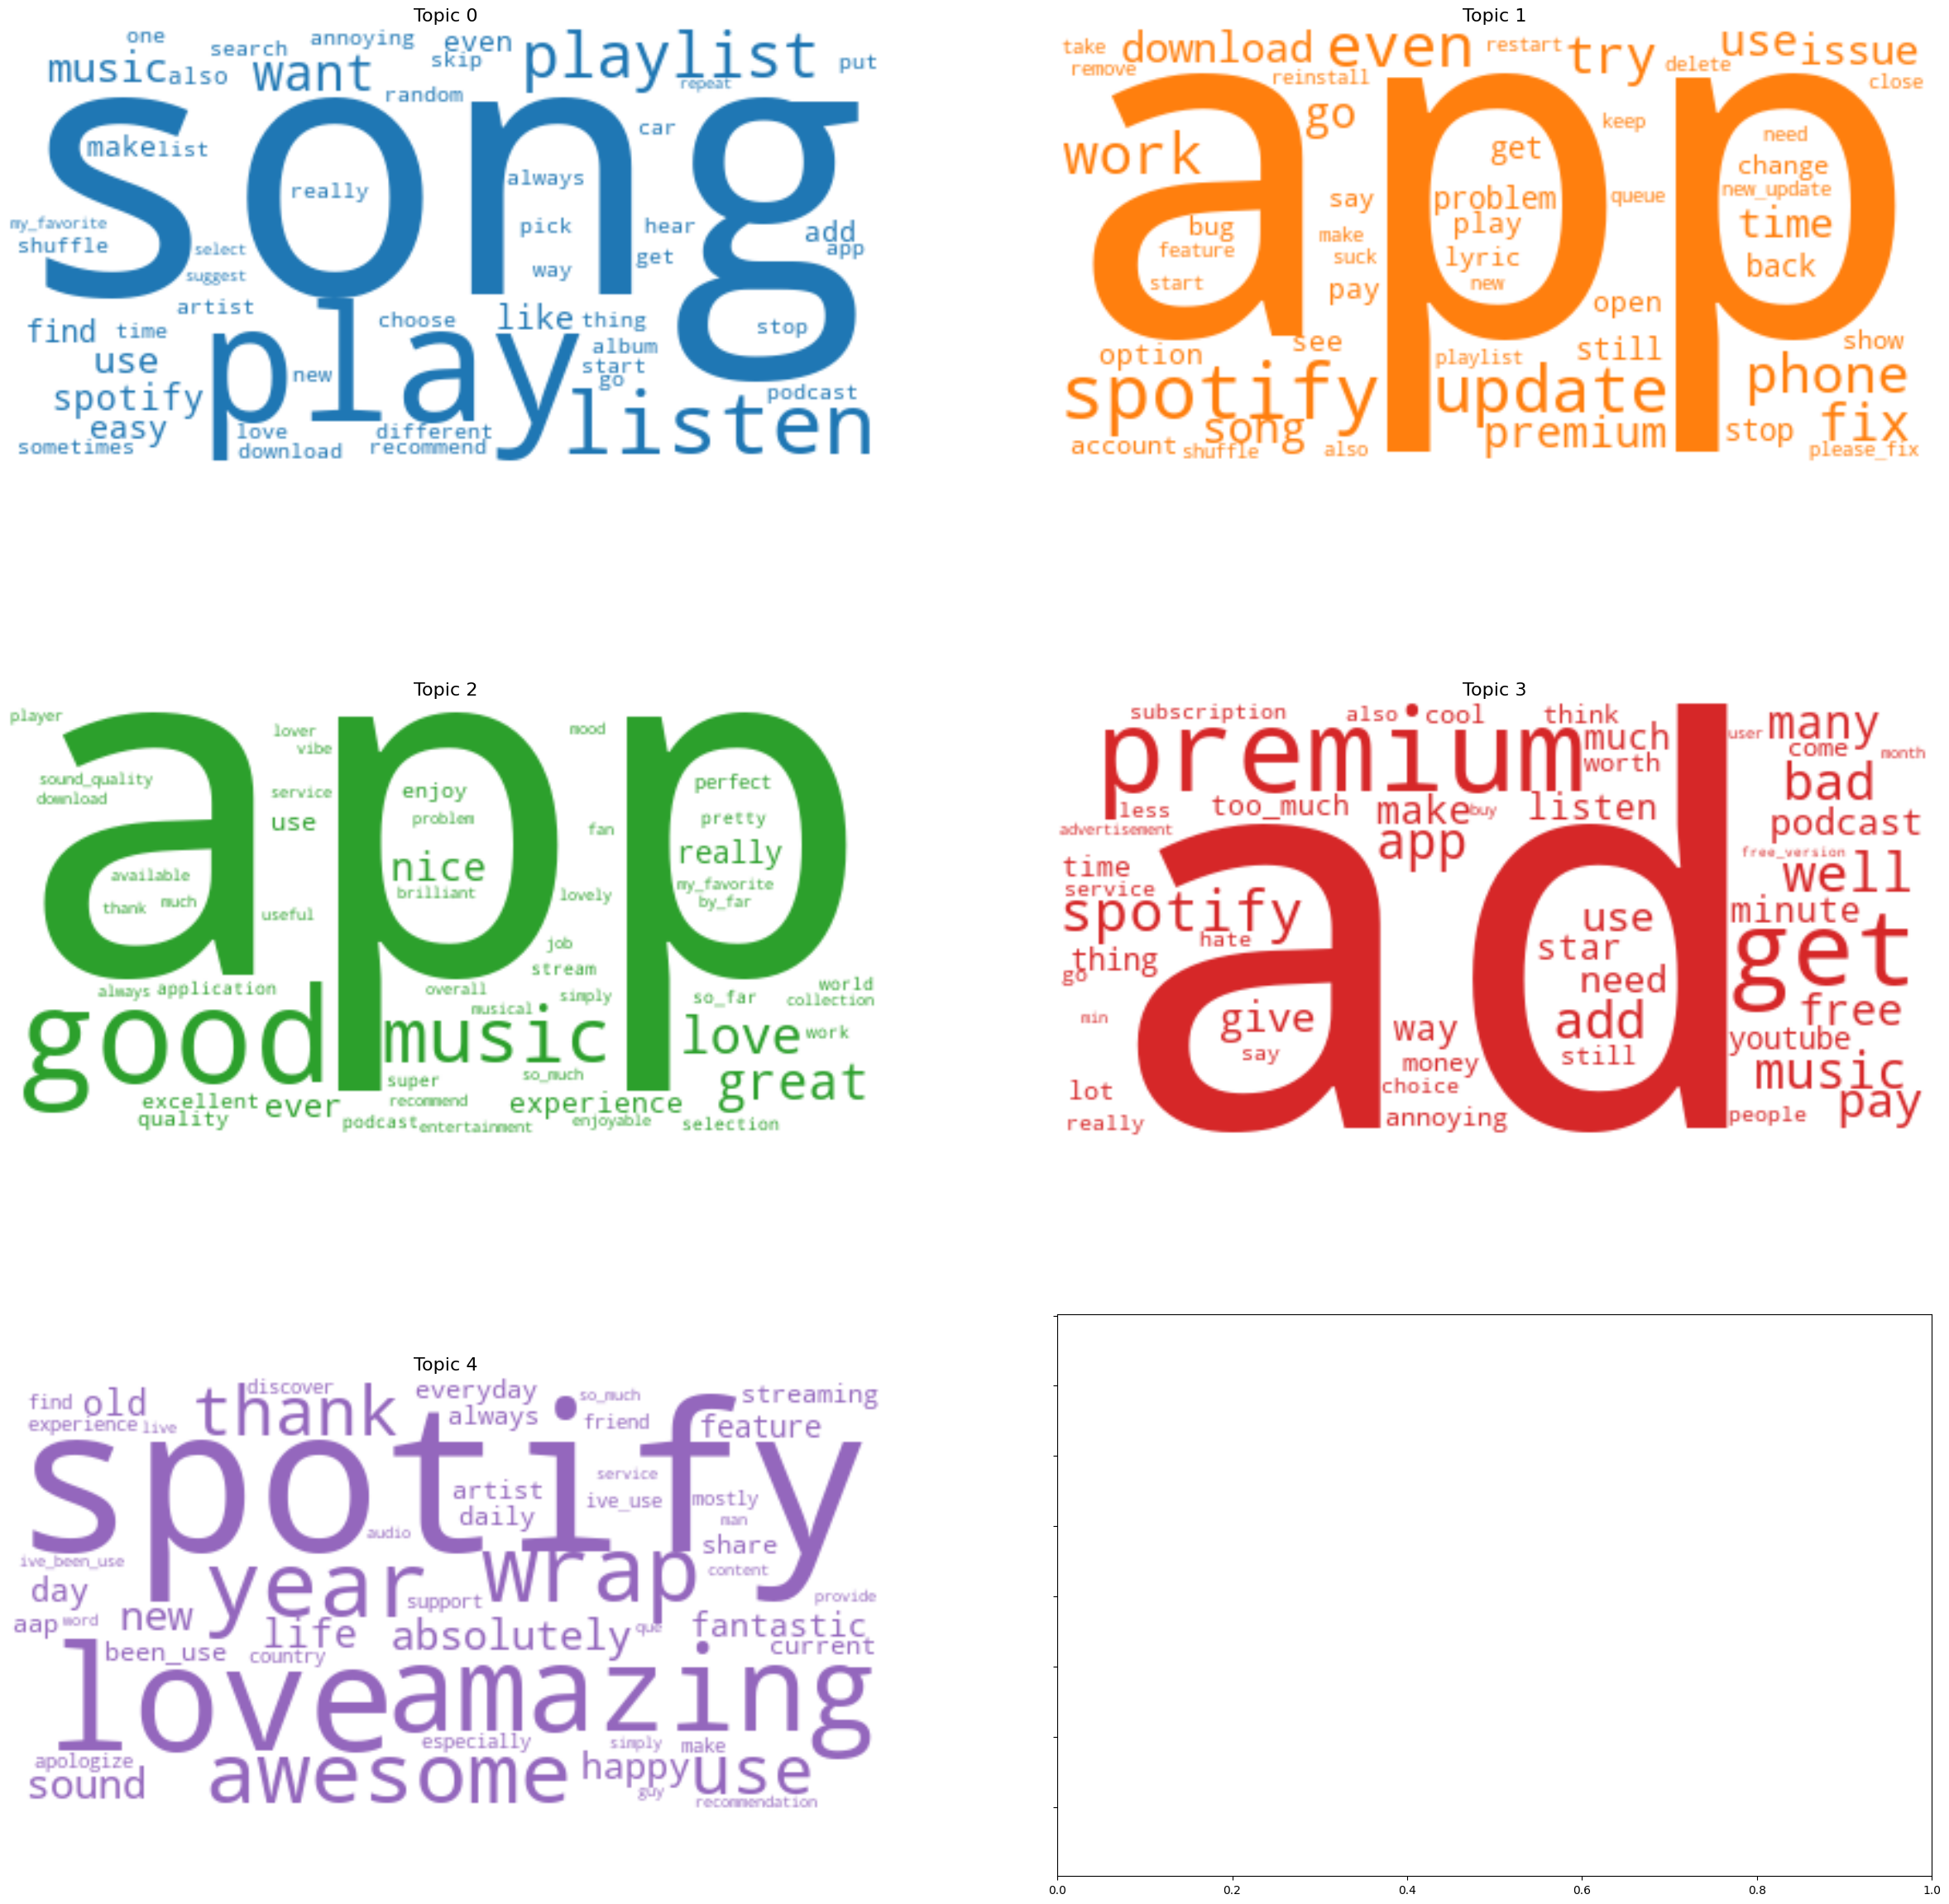

In [177]:
topics1 = lda_model1.show_topics(num_words=50,formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(30,30), sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words1 = dict(topics1[i][1])
    cloud.generate_from_frequencies(topic_words1, max_font_size=300)
    plt.gca().imshow(cloud,interpolation='bilinear')
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=5, hspace=5)
plt.axis('off')
plt.margins(x=5, y=5)
plt.tight_layout()
plt.show()

In [178]:
df_topic_sents_keywords1 = format_topics_sentences(ldamodel=lda_model1, corpus=corpus1, texts=texts1)

In [179]:

# Format
df_dominant_topic1 = df_topic_sents_keywords1.reset_index()
df_dominant_topic1.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic1.head(10)
df_before[['Before_Dominant_Topic', 'Before_Topic_Perc_Contrib', 'Before_Keywords']]=df_dominant_topic1[['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']].values


In [180]:
file_name = 'final_spotify_before_result.xlsx'
save_file = os.path.join(file_path, file_name)
df_before.to_excel(save_file,
                 engine='openpyxl',
                 startrow=0,
                 startcol=0,
                 header=True,
                 na_rep='NaN',
                 float_format='%.2f',
                 sheet_name='Sheet1'
                 )

after

In [181]:
data_lemmatized2=df_after['words']
id2word2= corpora.Dictionary(data_lemmatized2)

In [182]:
texts2=(data_lemmatized2)

In [183]:
#Term Document Frequency
corpus2=[id2word2.doc2bow(text) for text in texts2]

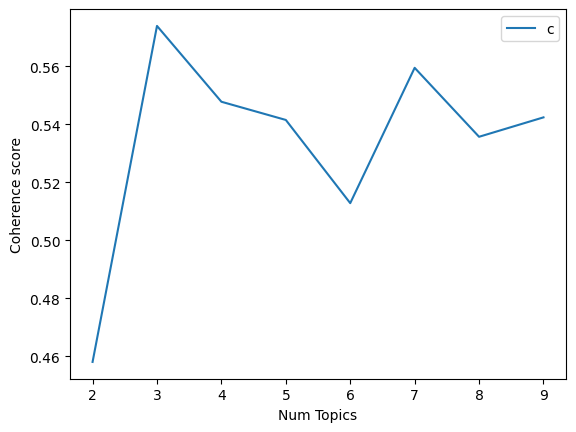

In [184]:

model_list2, coherence_values2 = compute_coherence_values(dictionary=id2word2, corpus=corpus2, texts=texts2, start=2, limit=10, step=1)

#Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [185]:

lda_model2= gensim.models.ldamodel.LdaModel(corpus=corpus2,id2word=id2word2,
                                           num_topics=3,random_state=100,
                                           alpha='auto',per_word_topics=True)


In [186]:
from pprint import pprint
doc_lda2=lda_model2[corpus2]
pprint(lda_model2.print_topics())


[(0,
  '0.152*"hate" + 0.097*"application" + 0.058*"bad" + 0.050*"app" + '
  '0.043*"spotify" + 0.021*"premium" + 0.013*"experience" + 0.012*"use" + '
  '0.010*"make" + 0.009*"get"'),
 (1,
  '0.136*"song" + 0.052*"play" + 0.047*"listen" + 0.036*"playlist" + '
  '0.027*"want" + 0.027*"add" + 0.022*"like" + 0.020*"even" + 0.015*"nice" + '
  '0.010*"skip"'),
 (2,
  '0.196*"app" + 0.062*"music" + 0.054*"good" + 0.030*"love" + 0.020*"ad" + '
  '0.019*"use" + 0.019*"great" + 0.015*"ever" + 0.014*"time" + 0.009*"work"')]


In [187]:

#compute perplexity
lda_perplexity2=lda_model2.log_perplexity(corpus2)
print('\nPerplexity:',lda_perplexity2)# a measure of how good the model is, lower the better.


#compute coherence score
coherence_model_lda2=CoherenceModel(model=lda_model2,texts=texts2,dictionary=id2word2,coherence='c_v')
coherence_lda2=coherence_model_lda2.get_coherence()
print('\nCoherence Score:',coherence_lda2)


Perplexity: -6.674266003881933

Coherence Score: 0.5337642338539855


In [188]:

vis2=pyLDAvis.gensim_models.prepare(lda_model2,corpus2,id2word2)
pyLDAvis.save_html(vis2,"spotify_after.html")


IndexError: list index out of range

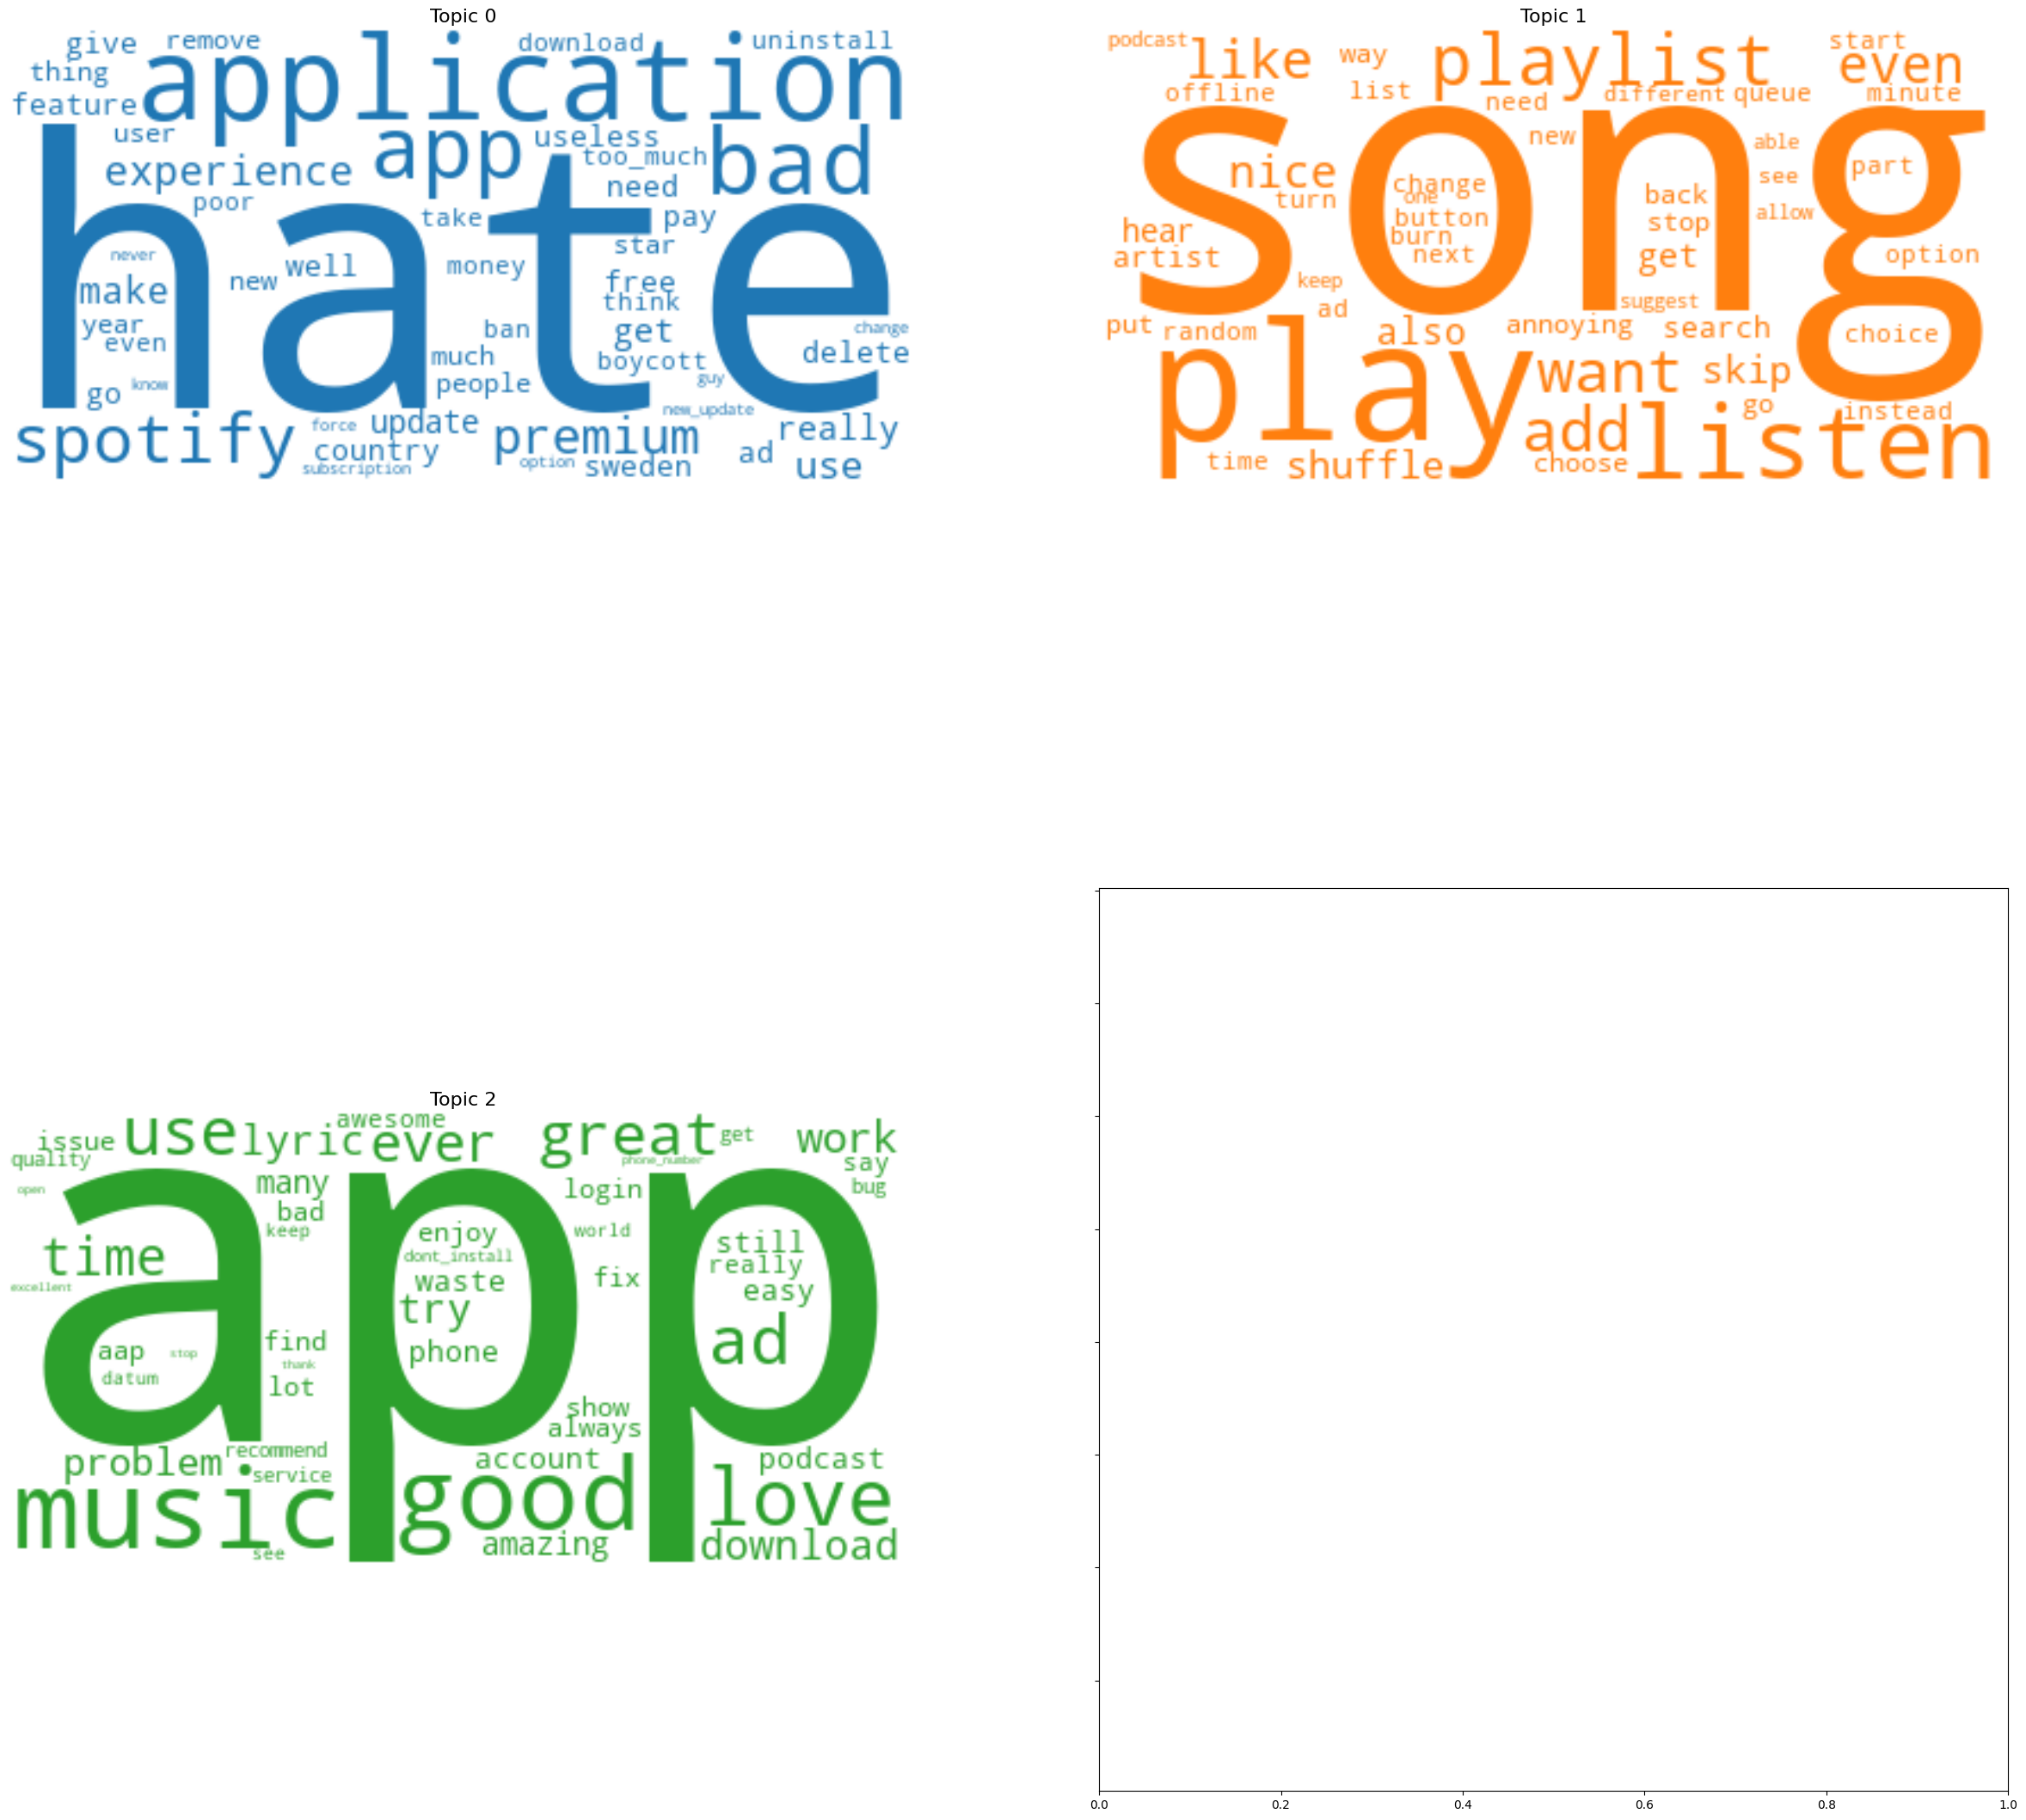

In [189]:
topics2 = lda_model2.show_topics(num_words=50,formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(30,30), sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words2 = dict(topics2[i][1])
    cloud.generate_from_frequencies(topic_words2, max_font_size=300)
    plt.gca().imshow(cloud,interpolation='bilinear')
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=5, hspace=5)
plt.axis('off')
plt.margins(x=5, y=5)
plt.tight_layout()
plt.show()

In [190]:
df_topic_sents_keywords2 = format_topics_sentences(ldamodel=lda_model2, corpus=corpus2, texts=texts2)

In [191]:

# Format
df_dominant_topic2 = df_topic_sents_keywords2.reset_index()
df_dominant_topic2.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic2.head(10)
df_after[['After_Dominant_Topic', 'After_Topic_Perc_Contrib', 'After_Keywords']]=df_dominant_topic2[['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']].values


In [192]:
file_name = 'final_spotify_after_result.xlsx'
save_file = os.path.join(file_path, file_name)
df_after.to_excel(save_file,
                 engine='openpyxl',
                 startrow=0,
                 startcol=0,
                 header=True,
                 na_rep='NaN',
                 float_format='%.2f',
                 sheet_name='Sheet1'
                 )

In [193]:
df_after['at']=pd.to_datetime(df_after["at"]).dt.date
odate=datetime.date(2023,10,1)

In [194]:
df_after_before_oct=df_after.loc[(df_after['at']<odate)].reset_index()
df_after_after_oct=df_after.loc[(df_after['at']>=odate)].reset_index()

Before Oct

In [195]:
data_lemmatized3=df_after_before_oct['words']
id2word3= corpora.Dictionary(data_lemmatized3)

In [196]:
texts3=(data_lemmatized3)

In [197]:
#Term Document Frequency
corpus3=[id2word3.doc2bow(text) for text in texts3]

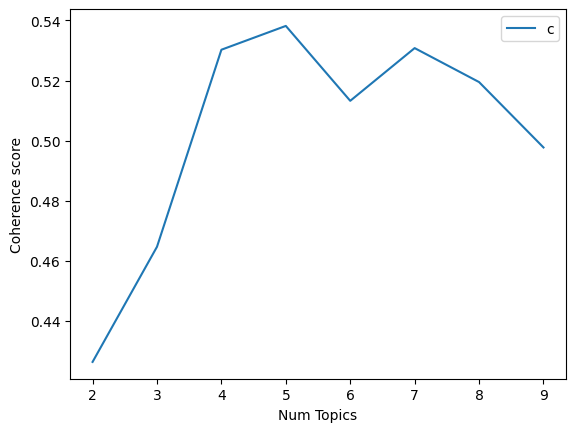

In [198]:

model_list3, coherence_values3 = compute_coherence_values(dictionary=id2word3, corpus=corpus3, texts=texts3, start=2, limit=10, step=1)

#Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [199]:

lda_model3= gensim.models.ldamodel.LdaModel(corpus=corpus3,id2word=id2word3,
                                           num_topics=5,random_state=100,
                                           alpha='auto',per_word_topics=True)


In [200]:
from pprint import pprint
doc_lda3=lda_model3[corpus3]
pprint(lda_model3.print_topics())


[(0,
  '0.038*"time" + 0.027*"work" + 0.021*"waste" + 0.019*"phone" + '
  '0.015*"spotify" + 0.013*"download" + 0.012*"app" + 0.012*"try" + '
  '0.012*"issue" + 0.011*"delete"'),
 (1,
  '0.041*"spotify" + 0.030*"premium" + 0.019*"lyric" + 0.015*"get" + '
  '0.012*"account" + 0.012*"year" + 0.012*"go" + 0.011*"use" + 0.011*"login" + '
  '0.010*"ban"'),
 (2,
  '0.332*"hate" + 0.210*"application" + 0.086*"app" + 0.053*"love" + '
  '0.018*"country" + 0.016*"nice" + 0.011*"sweden" + 0.009*"spotify" + '
  '0.006*"boycott" + 0.005*"awesome"'),
 (3,
  '0.257*"app" + 0.090*"bad" + 0.076*"music" + 0.067*"good" + 0.029*"use" + '
  '0.022*"great" + 0.022*"ever" + 0.017*"experience" + 0.016*"spotify" + '
  '0.011*"listen"'),
 (4,
  '0.119*"song" + 0.046*"play" + 0.043*"ad" + 0.032*"playlist" + '
  '0.031*"listen" + 0.026*"want" + 0.023*"add" + 0.019*"like" + 0.016*"even" + '
  '0.015*"get"')]


In [201]:

#compute perplexity
lda_perplexity3=lda_model3.log_perplexity(corpus3)
print('\nPerplexity:',lda_perplexity3)# a measure of how good the model is, lower the better.


#compute coherence score
coherence_model_lda3=CoherenceModel(model=lda_model3,texts=texts3,dictionary=id2word3,coherence='c_v')
coherence_lda3=coherence_model_lda3.get_coherence()
print('\nCoherence Score:',coherence_lda3)


Perplexity: -6.705638784532527

Coherence Score: 0.5307486618463951


In [202]:

vis3=pyLDAvis.gensim_models.prepare(lda_model3,corpus3,id2word3)
pyLDAvis.save_html(vis3,"final_spotify_after_before_oct.html")


IndexError: list index out of range

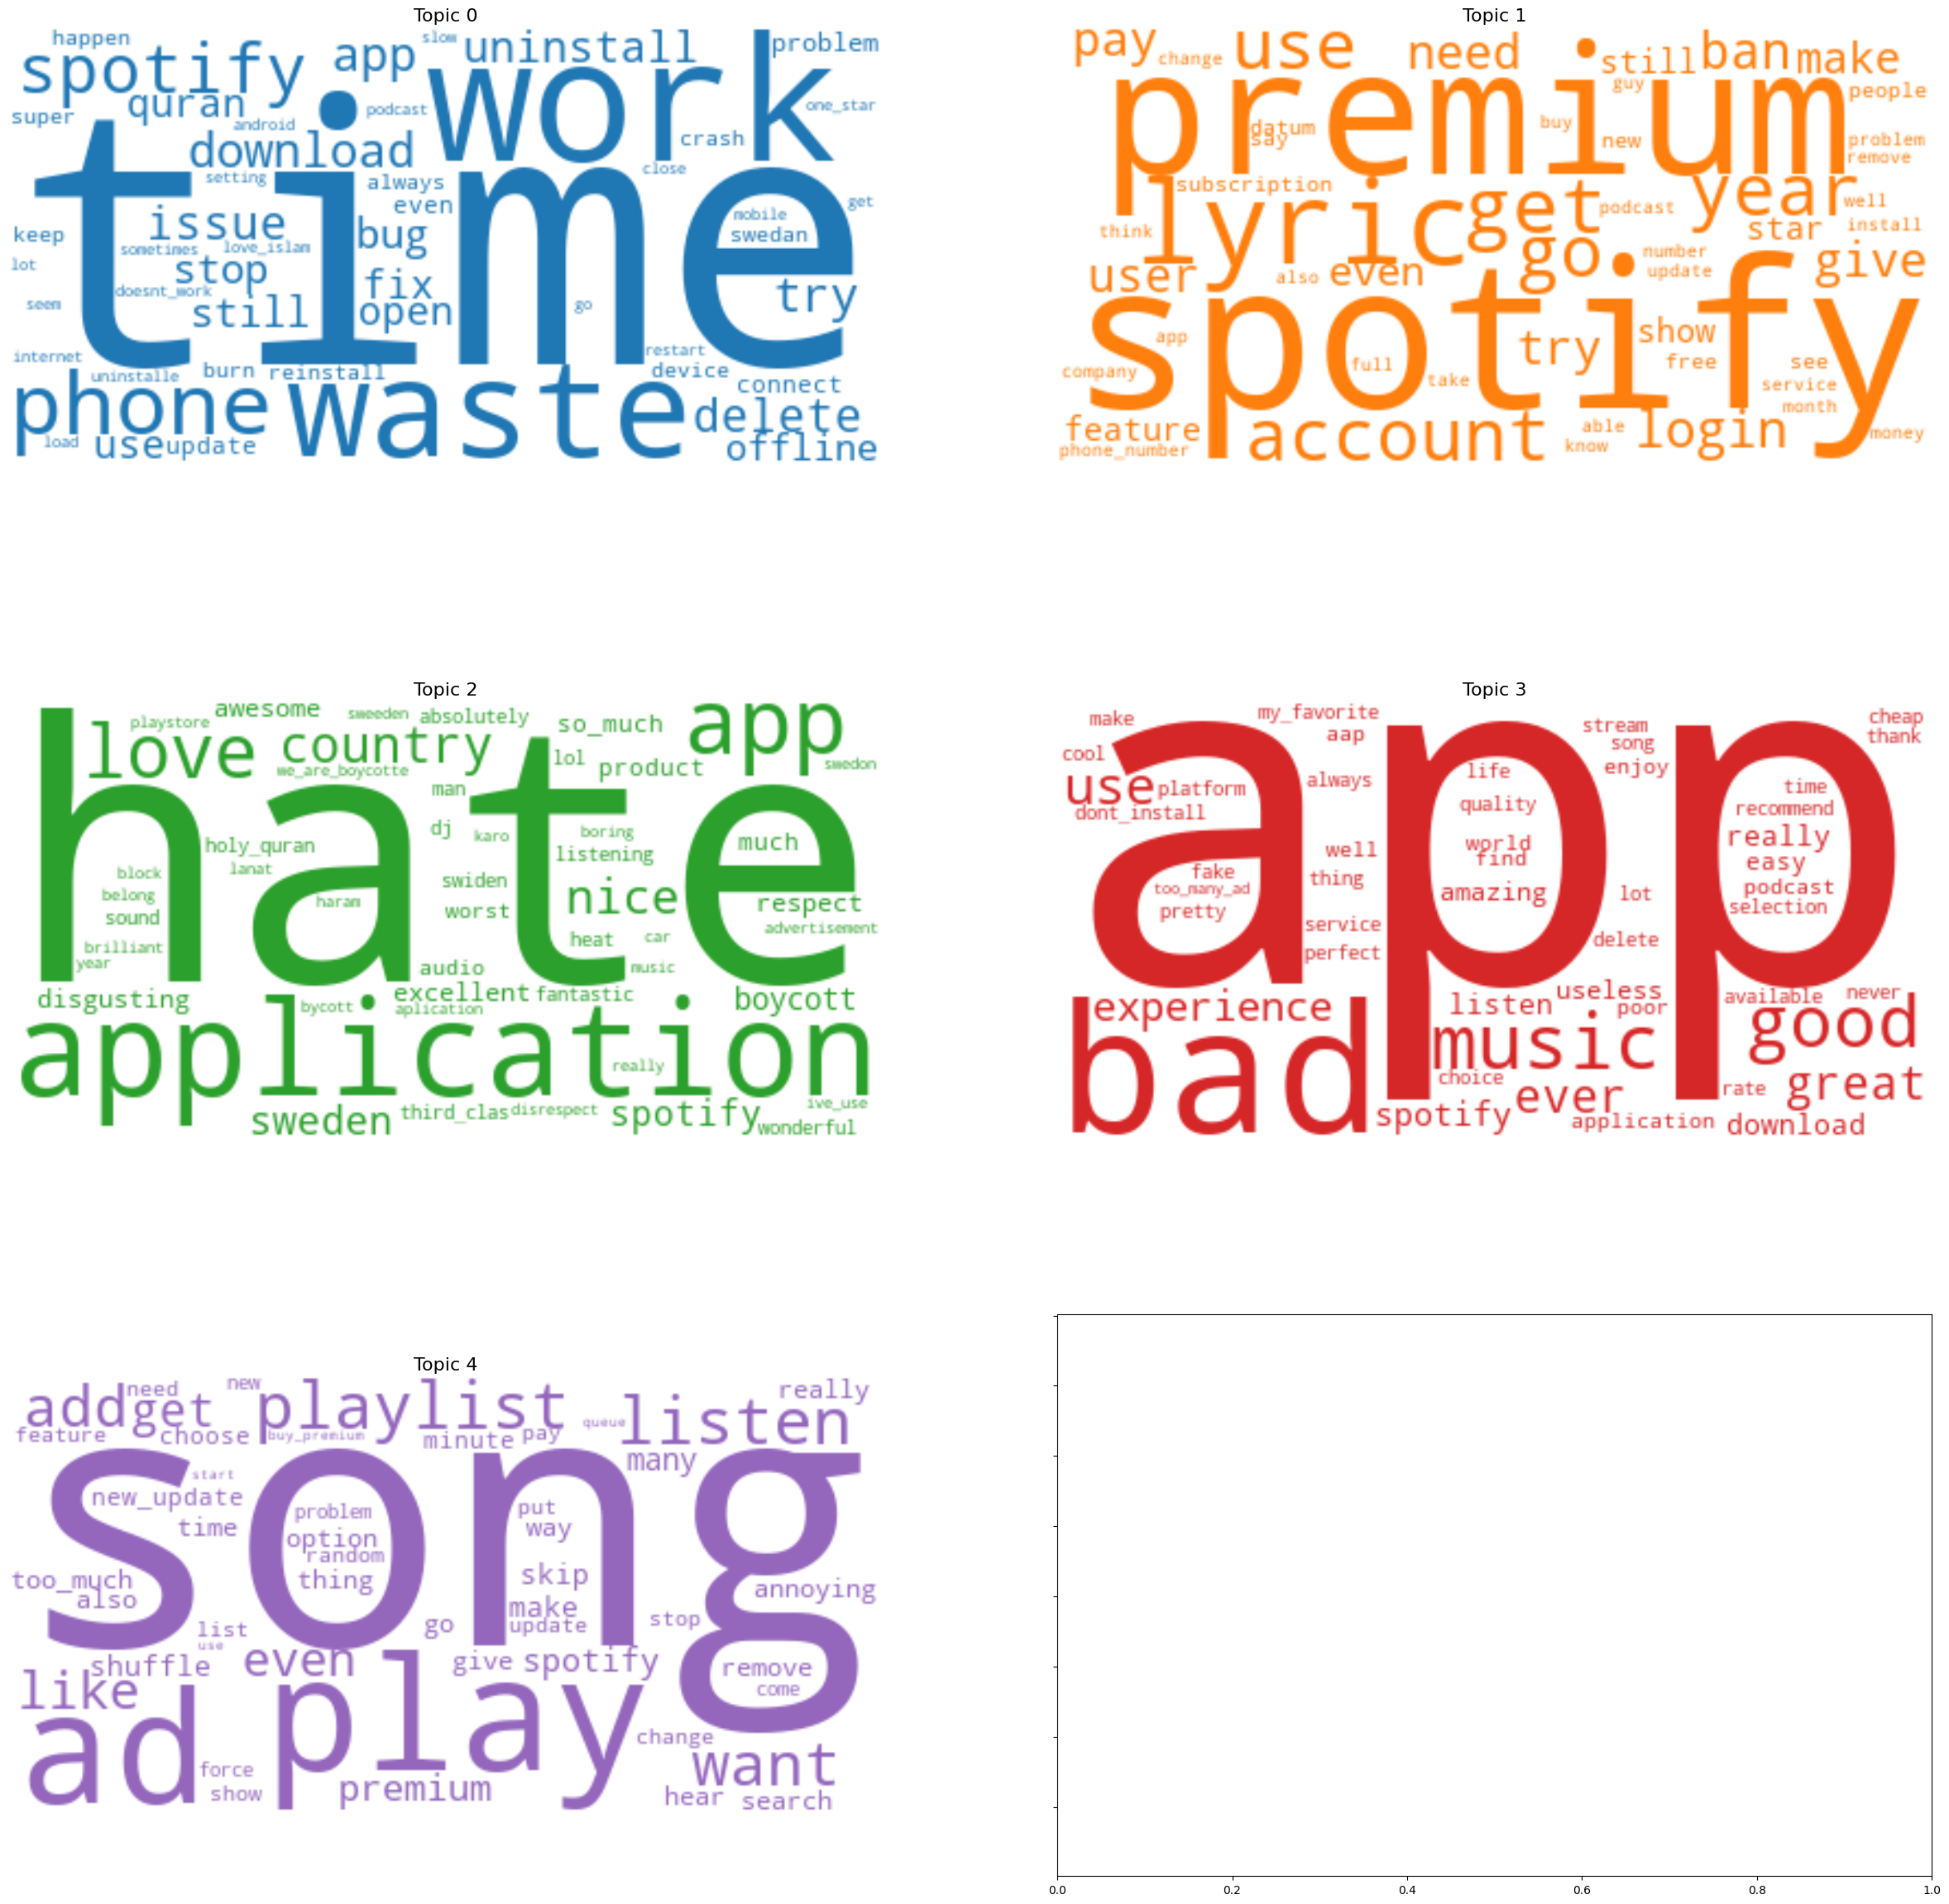

In [203]:
topics3 = lda_model3.show_topics(num_words=50,formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(30,30), sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words3 = dict(topics3[i][1])
    cloud.generate_from_frequencies(topic_words3, max_font_size=300)
    plt.gca().imshow(cloud,interpolation='bilinear')
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=5, hspace=5)
plt.axis('off')
plt.margins(x=5, y=5)
plt.tight_layout()
plt.show()

In [204]:
df_topic_sents_keywords3 = format_topics_sentences(ldamodel=lda_model3, corpus=corpus3, texts=texts3)

In [205]:

# Format
df_dominant_topic3 = df_topic_sents_keywords3.reset_index()
df_dominant_topic3.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic3.head(10)
df_after_before_oct[['OctB4_Dominant_Topic', 'OctB4_Topic_Perc_Contrib', 'OctB4_Keywords']]=df_dominant_topic3[['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']].values


In [206]:
file_name = 'final_spotify_after_before_oct_result.xlsx'
save_file = os.path.join(file_path, file_name)
df_after_before_oct.to_excel(save_file,
                 engine='openpyxl',
                 startrow=0,
                 startcol=0,
                 header=True,
                 na_rep='NaN',
                 float_format='%.2f',
                 sheet_name='Sheet1'
                 )

after oct

In [207]:
data_lemmatized4=df_after_after_oct['words']
id2word4= corpora.Dictionary(data_lemmatized4)

In [208]:
texts4=(data_lemmatized4)

In [209]:
#Term Document Frequency
corpus4=[id2word4.doc2bow(text) for text in texts4]

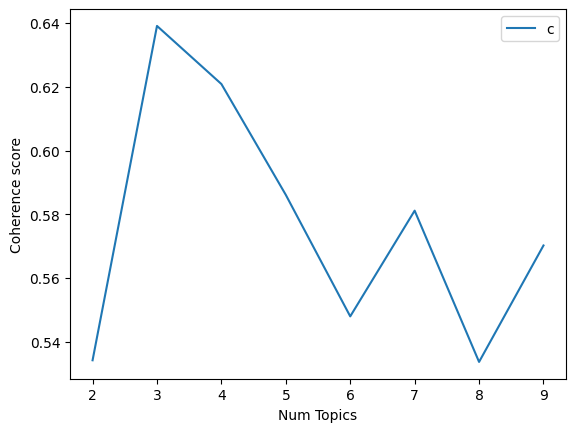

In [210]:

model_list4, coherence_values4 = compute_coherence_values(dictionary=id2word4, corpus=corpus4, texts=texts4, start=2, limit=10, step=1)

#Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values4)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [211]:

lda_model4= gensim.models.ldamodel.LdaModel(corpus=corpus4,id2word=id2word4,
                                           num_topics=3,random_state=100,
                                           alpha='auto',per_word_topics=True)


In [212]:
from pprint import pprint
doc_lda4=lda_model4[corpus4]
pprint(lda_model4.print_topics())


[(0,
  '0.059*"spotify" + 0.059*"premium" + 0.032*"update" + 0.021*"make" + '
  '0.018*"ad" + 0.017*"use" + 0.016*"new_update" + 0.015*"feature" + '
  '0.014*"get" + 0.012*"pay"'),
 (1,
  '0.124*"song" + 0.051*"play" + 0.033*"even" + 0.033*"listen" + 0.028*"lyric" '
  '+ 0.020*"playlist" + 0.019*"want" + 0.014*"add" + 0.014*"shuffle" + '
  '0.012*"like"'),
 (2,
  '0.204*"app" + 0.100*"music" + 0.074*"good" + 0.051*"bad" + 0.027*"love" + '
  '0.023*"use" + 0.019*"ever" + 0.019*"great" + 0.014*"listen" + '
  '0.012*"download"')]


In [213]:

#compute perplexity
lda_perplexity4=lda_model4.log_perplexity(corpus4)
print('\nPerplexity:',lda_perplexity4)# a measure of how good the model is, lower the better.


#compute coherence score
coherence_model_lda4=CoherenceModel(model=lda_model4,texts=texts4,dictionary=id2word4,coherence='c_v')
coherence_lda4=coherence_model_lda4.get_coherence()
print('\nCoherence Score:',coherence_lda4)


Perplexity: -6.421342448984338

Coherence Score: 0.549856957616524


In [214]:

vis4=pyLDAvis.gensim_models.prepare(lda_model4,corpus4,id2word4)
pyLDAvis.save_html(vis4,"final_spotify_after_after_oct.html")


IndexError: list index out of range

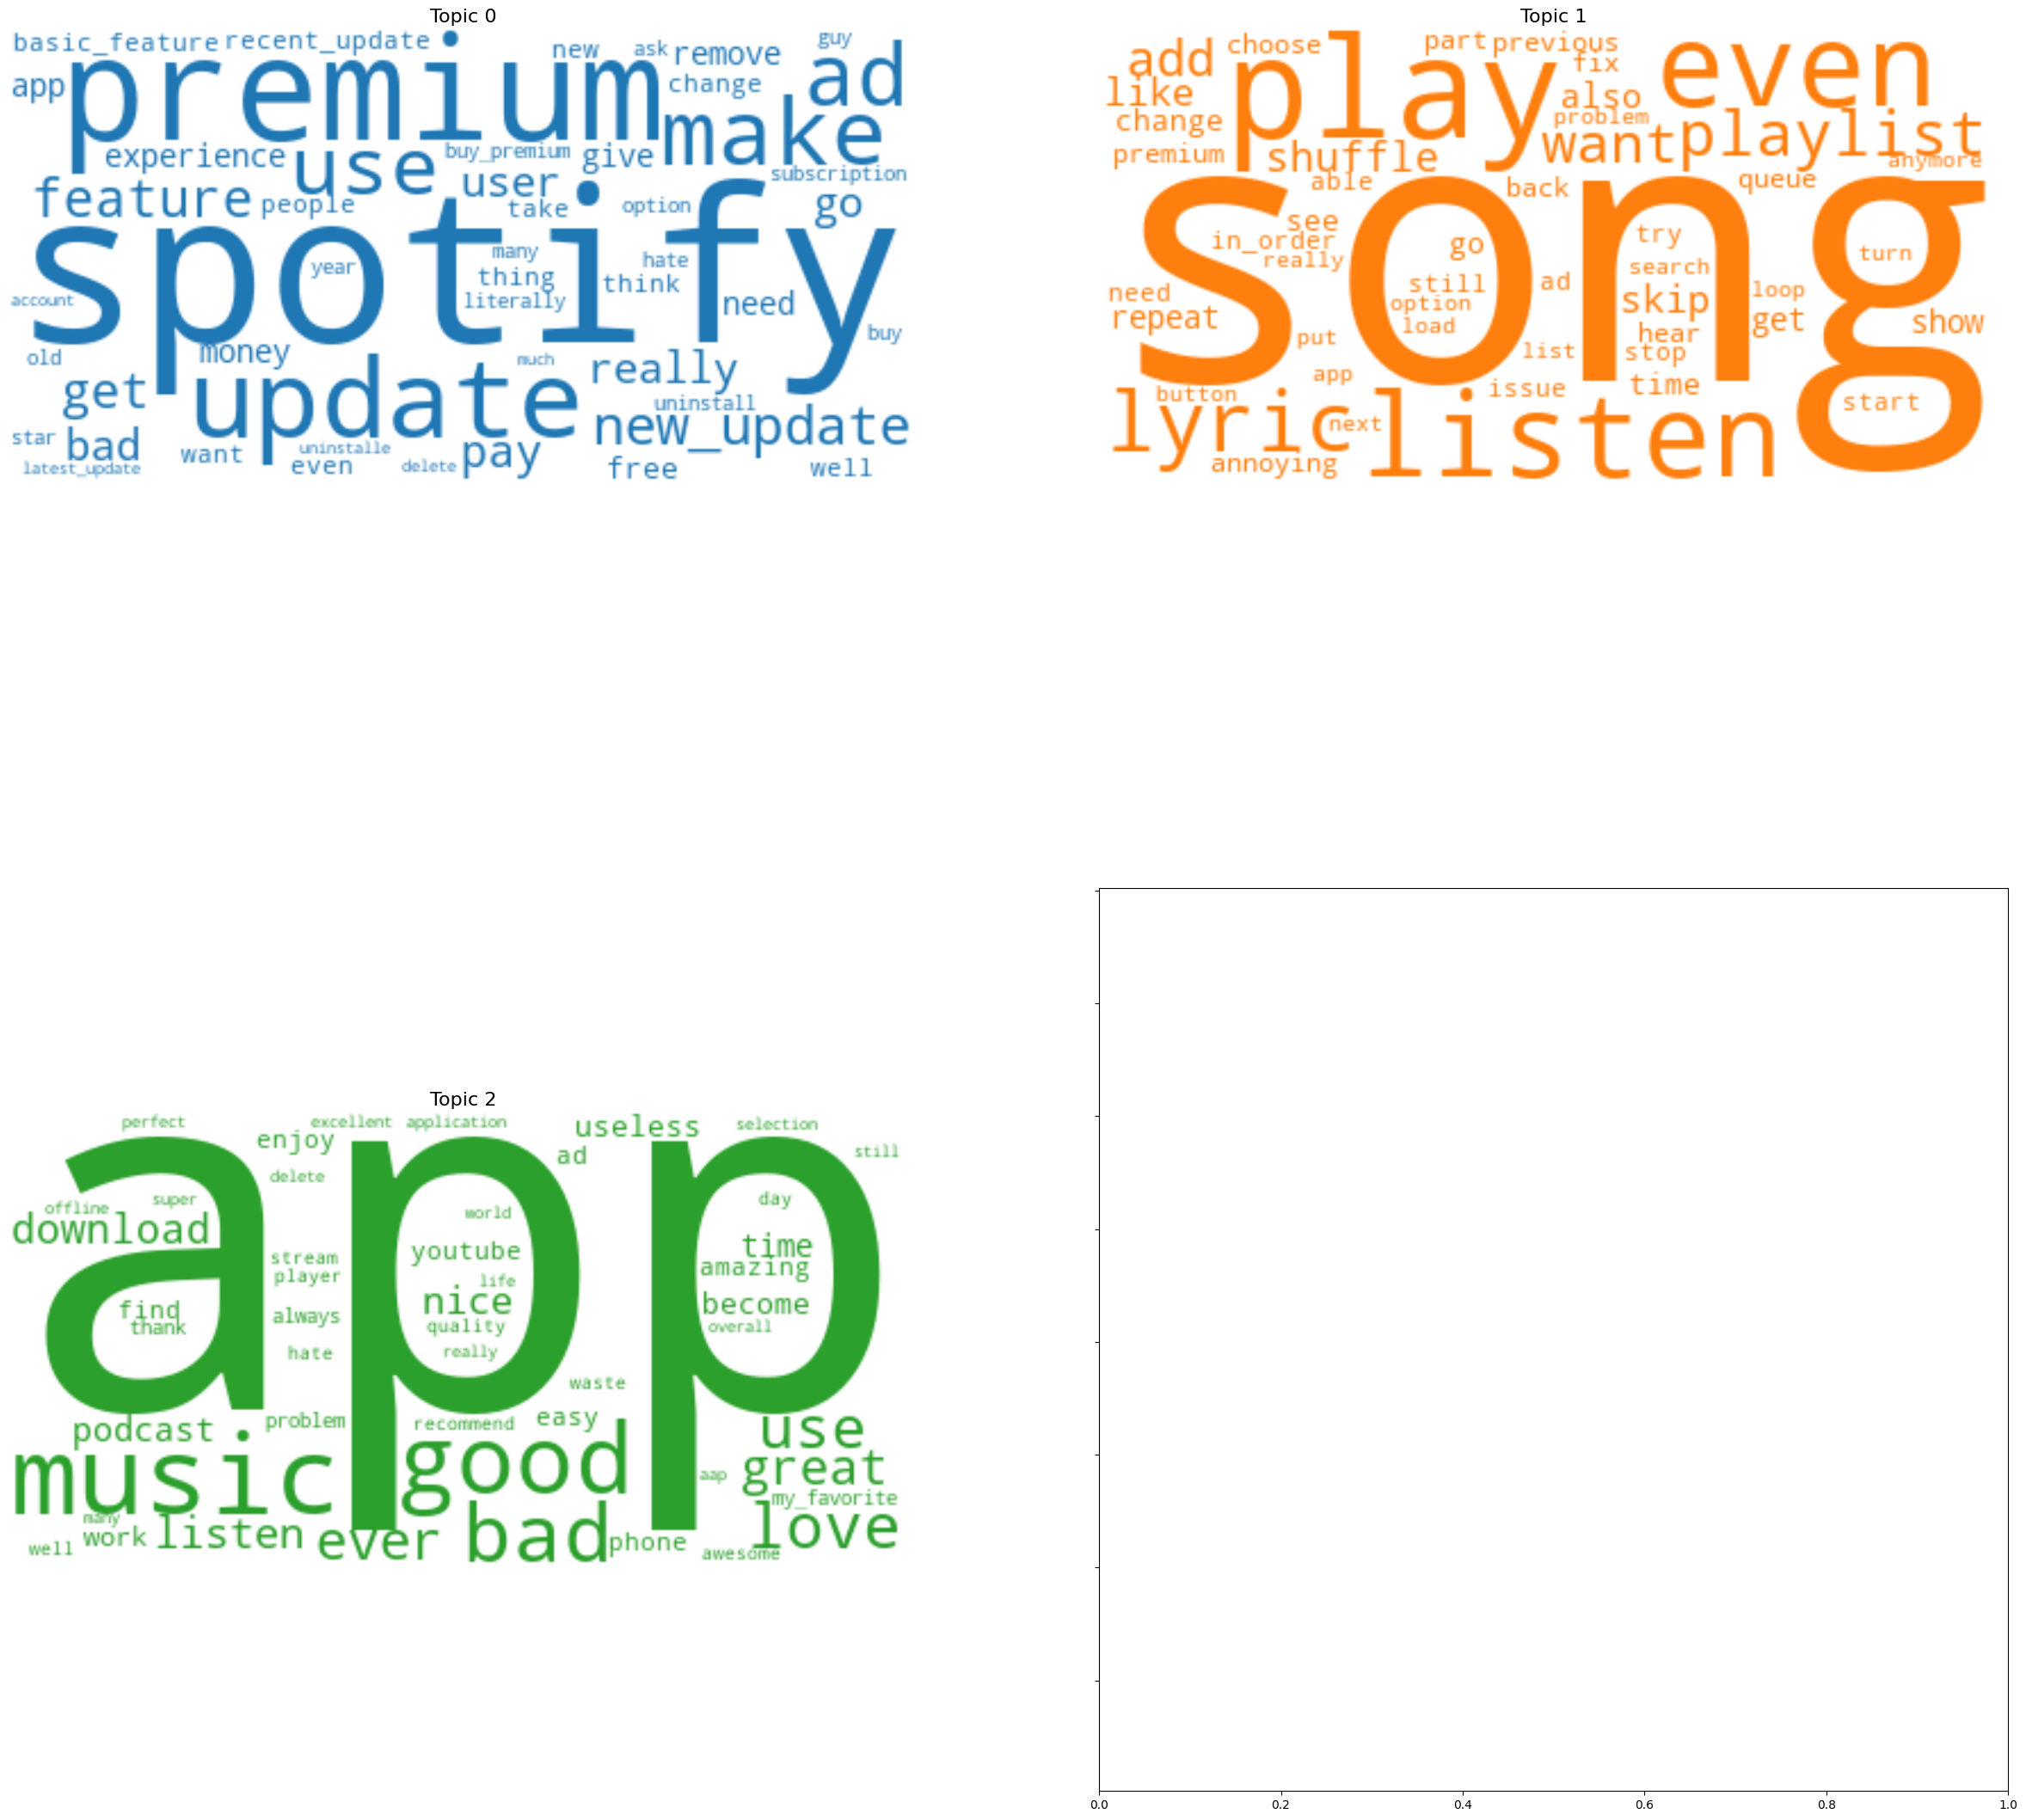

In [215]:
topics4 = lda_model4.show_topics(num_words=50,formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(30,30), sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words4 = dict(topics4[i][1])
    cloud.generate_from_frequencies(topic_words4, max_font_size=300)
    plt.gca().imshow(cloud,interpolation='bilinear')
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=5, hspace=5)
plt.axis('off')
plt.margins(x=5, y=5)
plt.tight_layout()
plt.show()

In [109]:
df_topic_sents_keywords4 = format_topics_sentences(ldamodel=lda_model4, corpus=corpus4, texts=texts4)

In [110]:

# Format
df_dominant_topic4 = df_topic_sents_keywords4.reset_index()
df_dominant_topic4.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic4.head(10)
df_after_after_oct[['Oct_Dominant_Topic', 'Oct_Topic_Perc_Contrib', 'Oct_Keywords']]=df_dominant_topic4[['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']].values


In [111]:
file_name = 'final_spotify_after_after_oct_result.xlsx'
save_file = os.path.join(file_path, file_name)
df_after_after_oct.to_excel(save_file,
                 engine='openpyxl',
                 startrow=0,
                 startcol=0,
                 header=True,
                 na_rep='NaN',
                 float_format='%.2f',
                 sheet_name='Sheet1'
                 )